In [33]:
%load_ext autoreload
%autoreload 2

import wandb
import pandas as pd
from typing import Any, Tuple
import math
import torch
from torch import tensor
import tqdm
import matplotlib
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

import quantisation.quantisation as Q

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
API = wandb.Api()

model_stats = {run.config["model"]: {k: dict(v) for k, v in run.summary["weight_stats"].items()}
               for run in API.runs("graphcore/sparse-attention-formats", {"config.experiment": "20250221-weight-stats"})}

runs = API.runs("graphcore/sparse-attention-formats", {"config.experiment": "20250219-initial-sweep-v2"})
print(len(runs))

1842


In [3]:
def load_run(run: wandb.apis.public.Run) -> dict[str, Any]:
    if "cross_entropy" in run.summary:
        fmt = run.config["format"]
        efmt = fmt["element_format"]
        if efmt["_type"] == "int":
            ename = "INT"
            ebits = efmt["bits_"]
        elif efmt["_type"] == "fp":
            ename = f"E{efmt['exponent_bits']}"
            ebits = 1 + efmt["exponent_bits"] + efmt["mantissa_bits"]
        elif efmt["_type"] == "lut":
            ename = efmt["name"]
            ebits = math.log2(len(efmt["values"]))
        return dict(
            # Config
            model=run.config["model"].split("/")[1],
            scaling=fmt["scaling"],
            group=tuple(fmt["group_shape"]),
            element=ename,
            element_bits=ebits,
            # Results
            cross_entropy=run.summary["cross_entropy"],
            kl_div=run.summary["kl_div"],
            bits_per_param=run.summary["bits_per_param"],
            weights=run.summary["weights"],
        )

df = pd.DataFrame.from_records(filter(None, map(load_run, tqdm.tqdm(runs))))
df.head()

  0%|          | 0/1842 [00:00<?, ?it/s]

100%|██████████| 1842/1842 [03:47<00:00,  8.11it/s]


,model,scaling,group,element,element_bits,cross_entropy,kl_div,bits_per_param,weights
0,Llama-3.2-1B,absmax,"(1, 16)",INT,2.0,13.730039,11.160234,3.638351,"{'lm_head.weight': {'bits': 788004864, 'quanti..."
1,Llama-3.2-1B,signmax,"(1, 16)",INT,2.0,6.701766,4.275428,3.638351,"{'lm_head.weight': {'bits': 788004864, 'quanti..."
2,Llama-3.2-1B,absmax,"(1, 16)",CRP-TG-S,2.0,12.246403,9.642605,3.638351,"{'lm_head.weight': {'bits': 788004864, 'quanti..."
3,Llama-3.2-1B,absmax,"(1, 16)",CRP-TL-S,2.0,11.974124,9.406010,3.638351,"{'lm_head.weight': {'bits': 788004864, 'quanti..."
4,Llama-3.2-1B,signmax,"(1, 16)",CRP-TG-A,2.0,6.393931,3.992848,3.638351,"{'lm_head.weight': {'bits': 788004864, 'quanti..."


In [8]:
model_order = ["Llama-3.2-1B", "Llama-3.2-3B", "Llama-3.1-8B", "gemma-2-2b", "gemma-2-9b", "phi-4"]

## KL divergence vs XEnt

(1.7, 3.2)

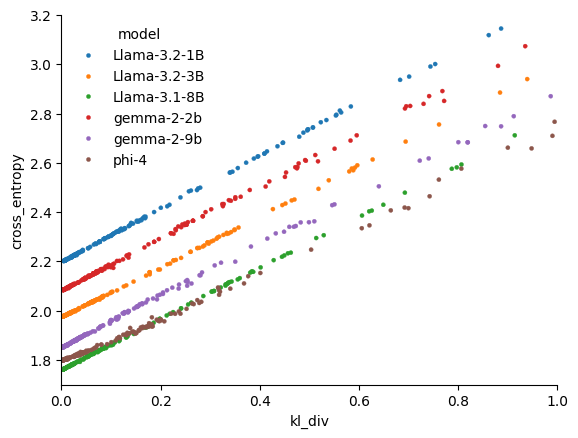

In [5]:
ax = sns.scatterplot(data=df, y="cross_entropy", x="kl_div", hue="model", edgecolor=None, s=9)
ax.set_xlim((0, 1))
ax.set_ylim((1.7, 3.2))

## Group format comparison

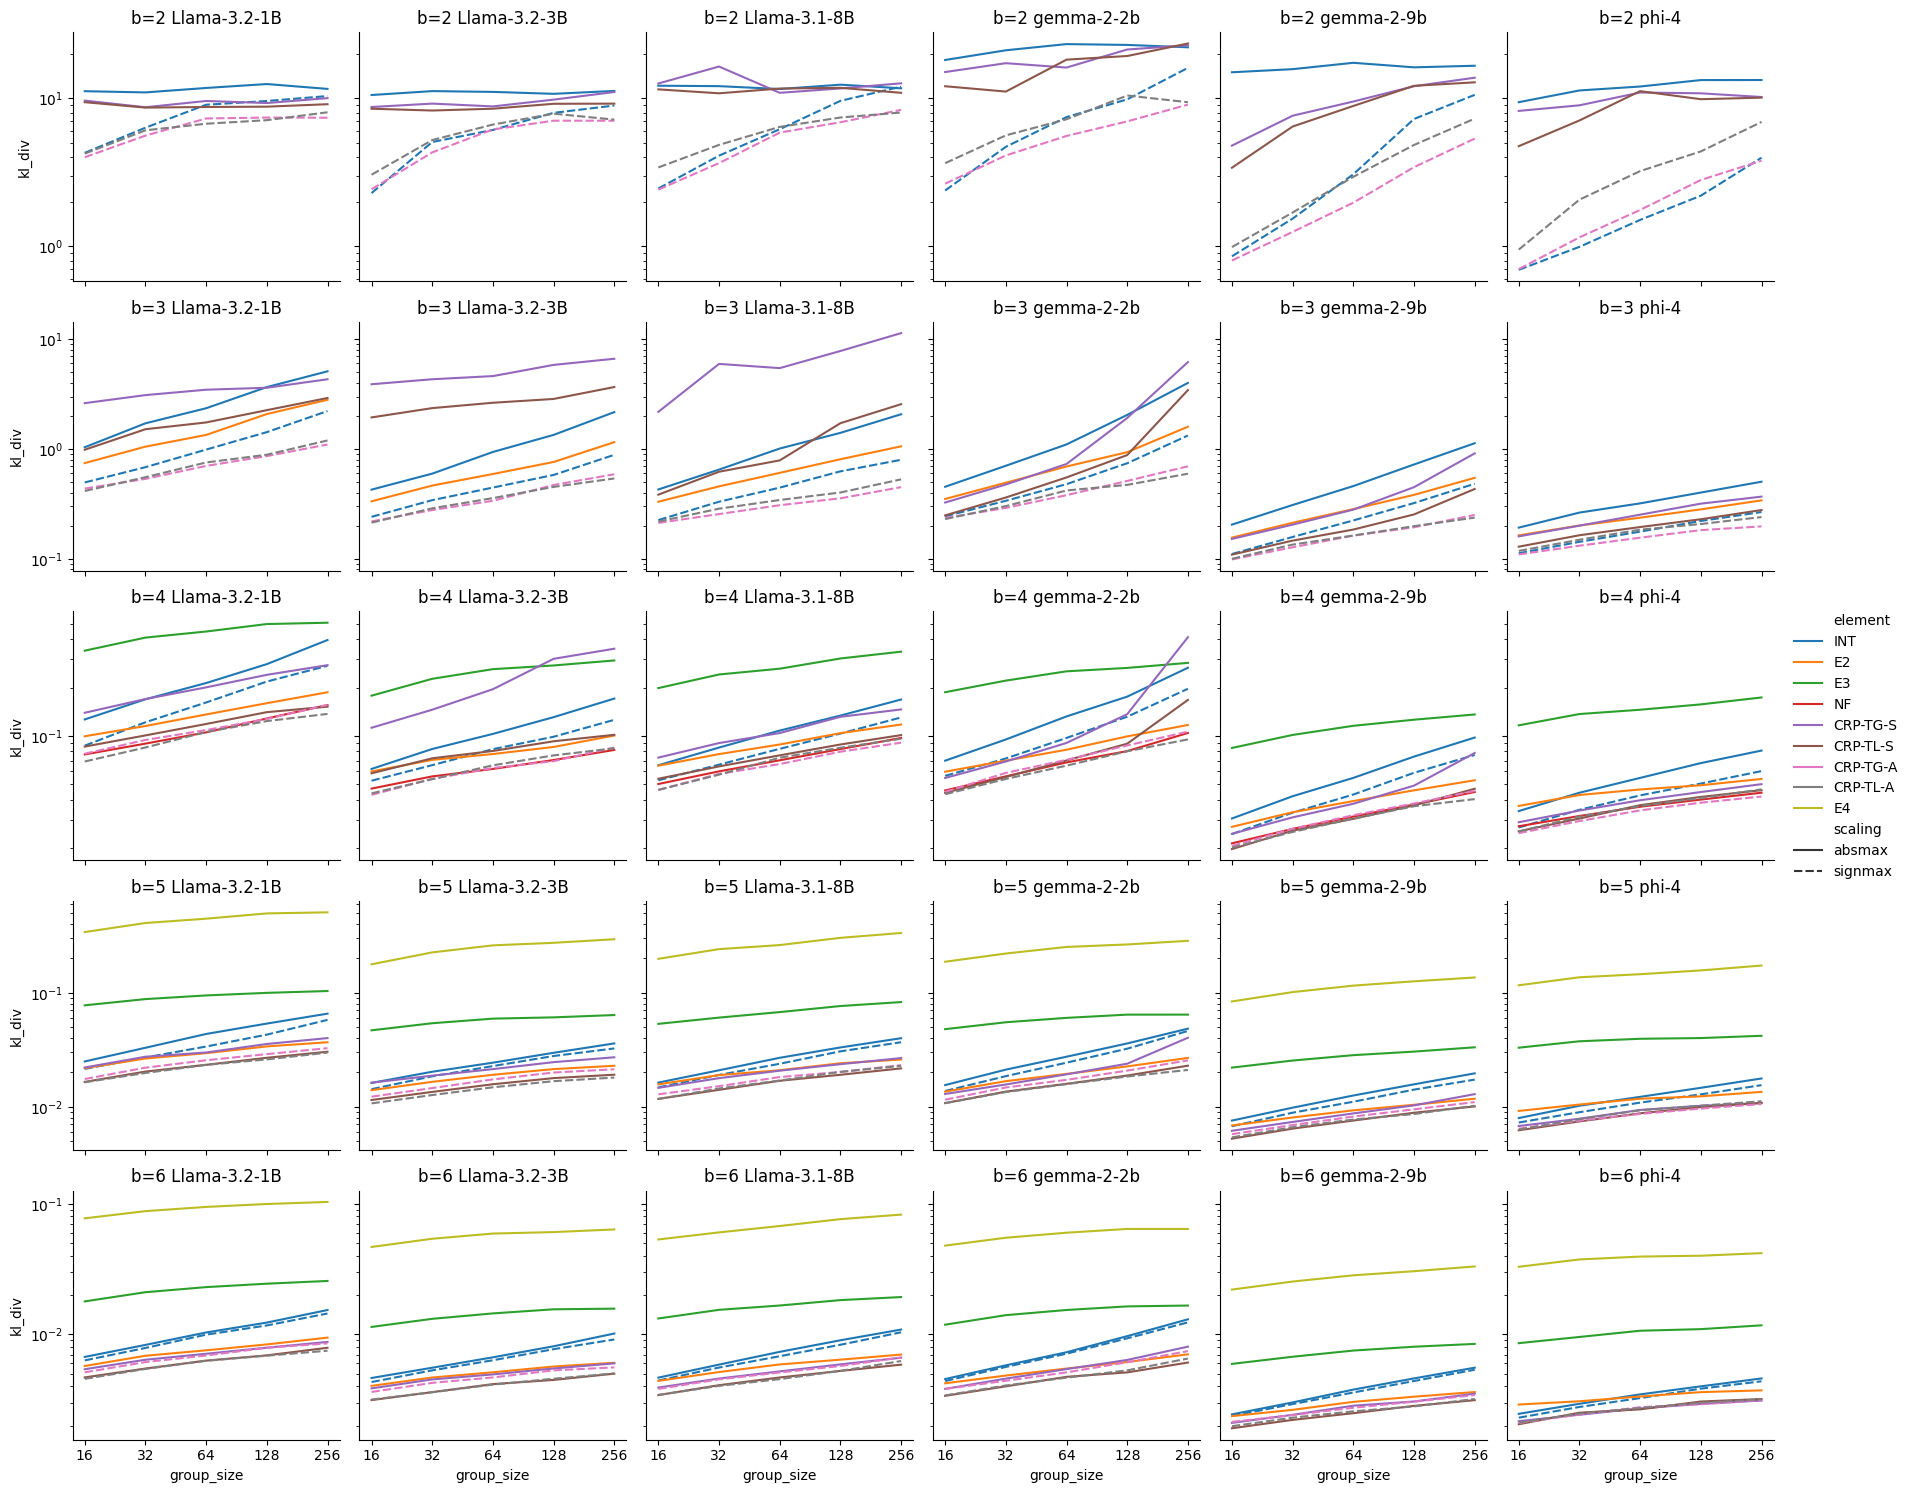

In [46]:
d = df.pipe(lambda d: d.assign(group_size=d.group.apply(lambda x: x[1]))).dropna(subset=["group_size"])
g = sns.relplot(d.sort_values("group_size"), y="kl_div", x="group_size", hue="element", style="scaling",
                col="model", col_order=model_order, row="element_bits",
                kind="line", facet_kws=dict(sharey="row"), height=3)
for (element_bits, model), ax in g.axes_dict.items():
    ax.set_xscale("log", base=2)
    ax.set_title(f"b={element_bits:.0f} {model}")
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter("{x:.0f}")

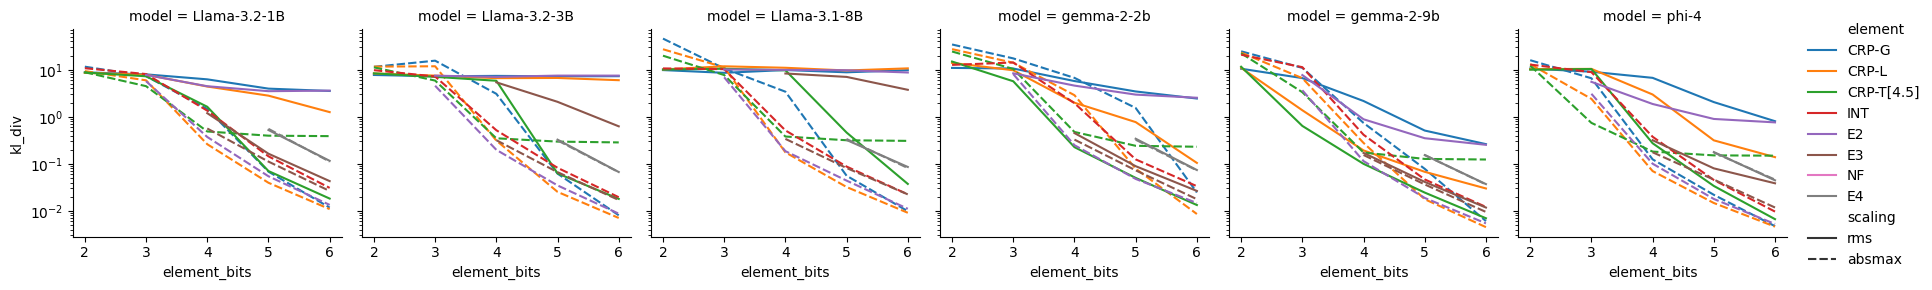

In [12]:
d = df.pipe(lambda d: d[d.group == (1, None)])
g = sns.relplot(data=d, y="kl_div", x="element_bits", hue="element", style="scaling",
                col="model", col_order=model_order,
                kind="line", height=3)
for ax in g.axes.flatten():
    ax.set_yscale("log")

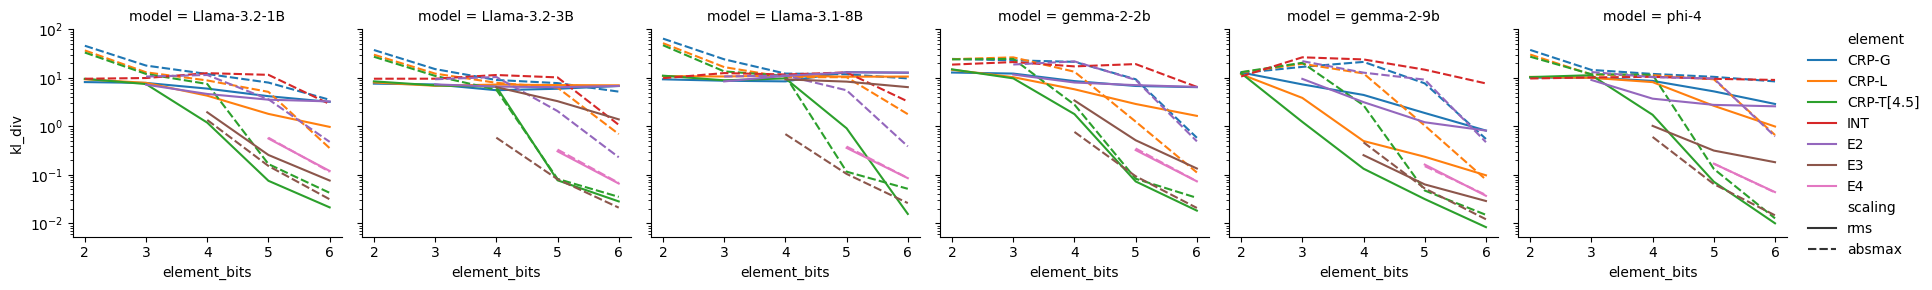

In [13]:
d = df.pipe(lambda d: d[d.group == (None, None)])
g = sns.relplot(data=d, y="kl_div", x="element_bits", hue="element", style="scaling",
                col="model", col_order=model_order,
                kind="line", height=3)
for ax in g.axes.flatten():
    ax.set_yscale("log")

## Overall trade-off

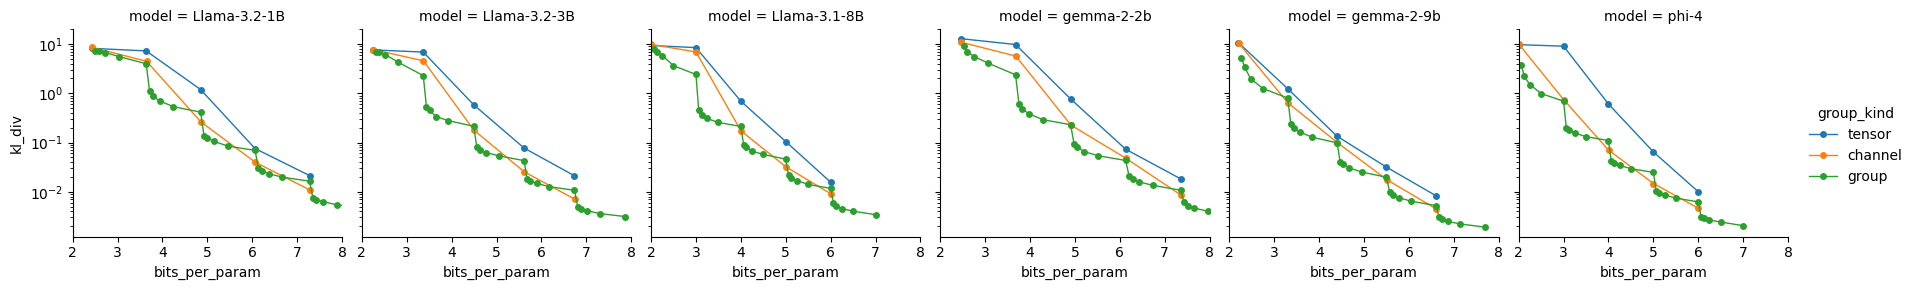

In [45]:
def group_kind(g: Tuple[int | None, int | None]) -> str:
    if g == (None, None):
        return "tensor"
    if g == (1, None):
        return "channel"
    return "group"

d = (df.pipe(lambda d: d.assign(group_kind=d.group.apply(group_kind)))
    .pipe(lambda d: d.assign(group_size=d.group.apply(lambda x: x[1])))
    .groupby(["model", "group_kind", "group_size", "element_bits"], dropna=False).apply(lambda g: g.iloc[g.kl_div.argmin()], include_groups=False)
    .reset_index()
)
g = sns.relplot(data=d.sort_values("bits_per_param"), y="kl_div", x="bits_per_param", hue="group_kind", hue_order=["tensor", "channel", "group"],
                col="model", col_order=model_order,
                kind="line", marker="o", markeredgewidth=0, ms=5, lw=1, height=3)
for ax in g.axes.flatten():
    ax.set_yscale("log")
    ax.set_xlim((2, 8))

## Per-weight

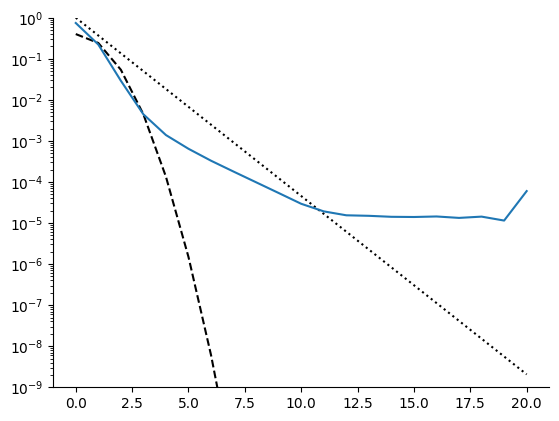

In [47]:
s = model_stats["meta-llama/Llama-3.1-8B"]["lm_head.weight"]
s = model_stats["google/gemma-2-9b"]["lm_head.weight"]
_, ax = plt.subplots()
xs = torch.arange(0, 20 + 1)
ax.plot(xs, scipy.stats.norm.pdf(xs), "k--")
ax.plot(xs, scipy.stats.expon.pdf(xs), "k:")
ax.plot(xs, s["hist"])
ax.set_yscale("log")
ax.set_ylim((10**-9, 1));